<a href="https://colab.research.google.com/github/Quratulainmumtaz/Full_project_of_Sentement_Anaysis/blob/main/Full_project_for_Programming_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents
1. Problem Definition
2. Data Collection
3. Data Preparation
4. Model Training
5. Model Evaluation
6. Deployment



What is Sentiment Analysis ?
Sentiment analysis is the process of reading tons of product reviews automatically and extract useful and meaningful information to discover if the customers are really satisfied with your product or not.
A person’s feedback is more subjective rather than factual. Feedbacks can be negative, positive, or neutral.
Sentiment analysis applies Natural Language Processing (NLP) and Text Analysis techniques to highlight the subjective information from the text.Performing the sentiment analysis on the customer reviews can help identify what is lacking and therefore guide you to improvement.
You can review customer feedback and responses, and thus identify the negative comments and reasons why the customers have issues with your product or service.

Objective
Aim : To determine the sentiment of a given review. (Negative/ Neutral/ Positive)
ML Task : Supervised Learning Multi-Class Text Classification
Performance metrics : Accuracy, Confusion matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

Load data

In [2]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


The shape of a DataFrame is a tuple of array dimensions that tells the number of rows and columns of a given DataFrame

In [3]:
data.shape

(568454, 10)

Data cleaning
Data cleaning
Handling missing values

In [4]:
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Remove rows which are having null values

In [5]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 43

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


Remove duplicate rows

In [6]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174750

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


Remove outliers

In [7]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


Create target column using Score

Loc and iloc are two functions in Pandas that are used to slice a data set in a Pandas DataFrame. The function .loc is typically used for label indexing and can access multiple columns, while .iloc is used for integer & boolan indexing.

In [8]:
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [9]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
57816,5,Positive
423672,5,Positive
38128,5,Positive
6367,1,Negative
391717,5,Positive


Handling class imbalance

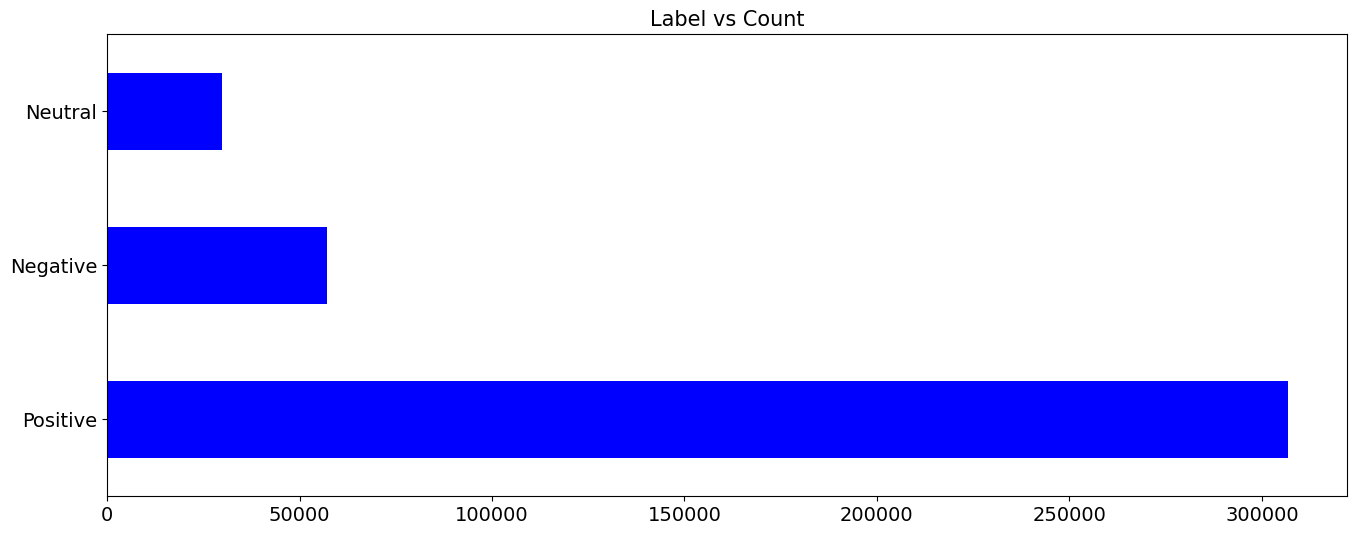

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Down sampling (remove some positive and negative reviews)

In [11]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

Target distribution (after)

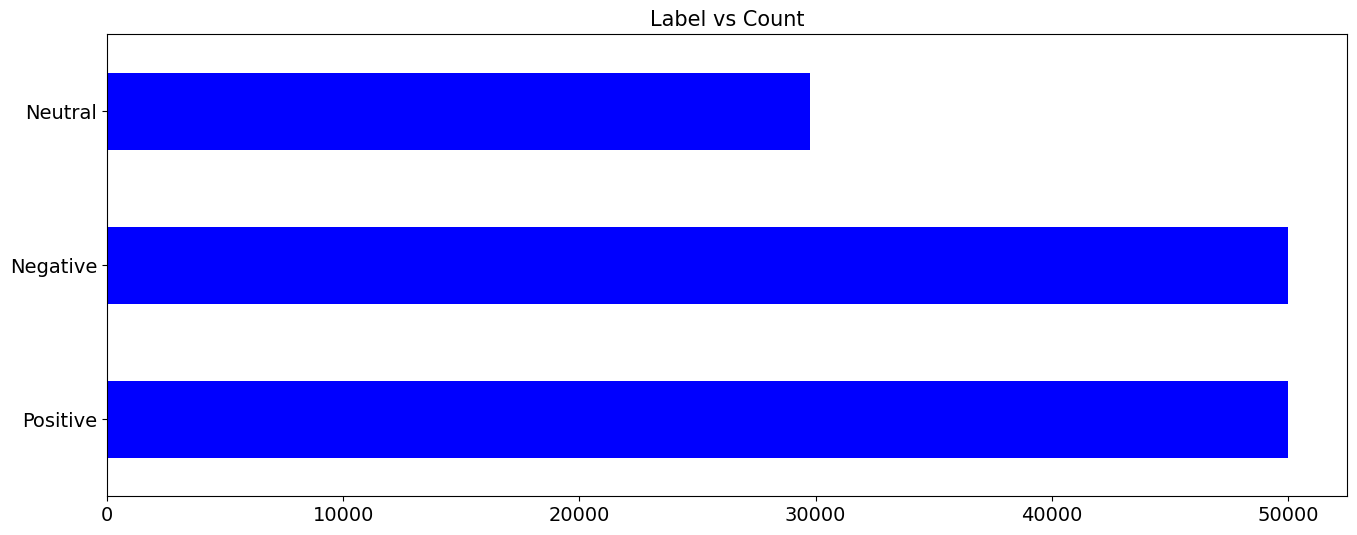

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Data Pre-processing
Stop words

In [15]:
# stopwords
import nltk
nltk.download('stopwords')
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'down', 'until', 'being', 'against', 'herself', 'is', 'and', 'our', 'into', 'off', 'should', 'over', 'are', 'up', 'didn', 'out', 'he', 'with', 'because', 'we', 'be', "it's", 'can', 'has', 'one', 'same', "you've", 'she', 'aren', 'yourselves', 'ma', 'so', 'its', 'about', 'both', "you'd", 'you', 'your', 'hadn', 'were', 'or', 'haven', 'as', 'whom', 'in', 'above', 'y', 'at', 'that', 'but', 'when', 'more', 'there', 'ourselves', 'then', 'doing', 'having', 'shouldn', 'mustn', 'hasn', 'o', 'further', 'any', 'than', "you'll", 'does', 'them', 'each', 'did', 'yourself', 'own', 'some', "she's", 'where', 'i', 'here', 'won', 'wasn', 't', 'by', 'have', 'for', 'they', 'after', 'll', 'during', 'these', 'ours', 'before', 'his', 'her', 'm', 'weren', 'again', 's', 'himself', 'their', 'only', 'my', 'under', 're', 'will', 'shan', 'such', 'was', "should've", 'those', 'while', 'once', 'wouldn', 'yours', 'why', 'mightn', 'hers', 'the', 'been', 'from', 'most', 'through', 'ain', 'him', 'd', 'a', 'themselves', 'c

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Remove unwanted words from reviews
Ex. html tags, punctuation, stop words, etc

In [16]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [17]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

print("Before preprocessing : ")
data.Text.iloc[6]

In [18]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'is the est coffee. Thanks to Amazon.com offer the chance to deliver it. Unfortunely 2 of 9 bags was unsealed.'

In [19]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'est coffe thank amazoncom offer chanc deliv unfortun bag unseal'

Word clouds

In [20]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

Word cloud for Positive reviews

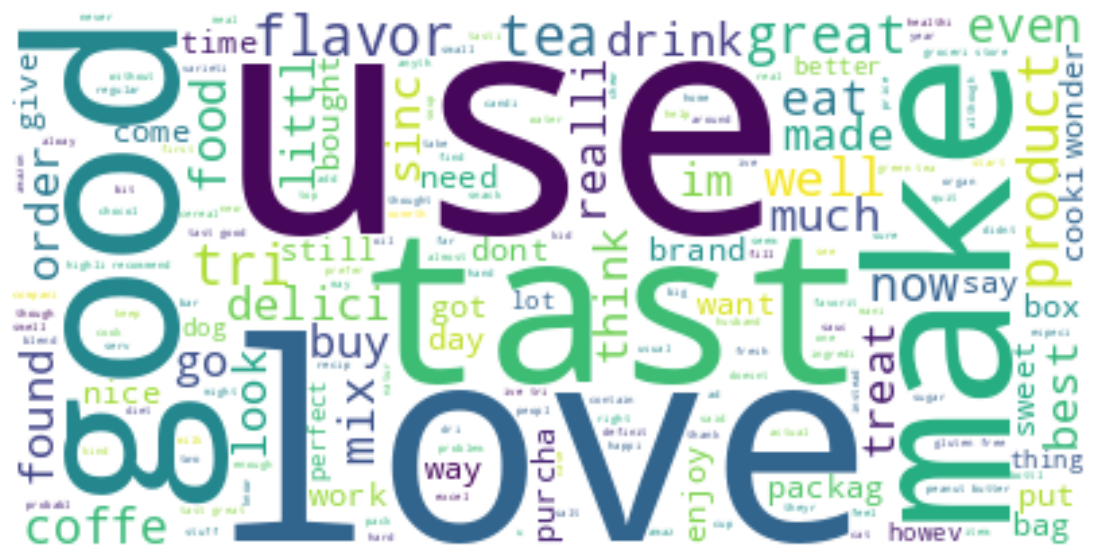

In [21]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Word cloud for Negative reviews

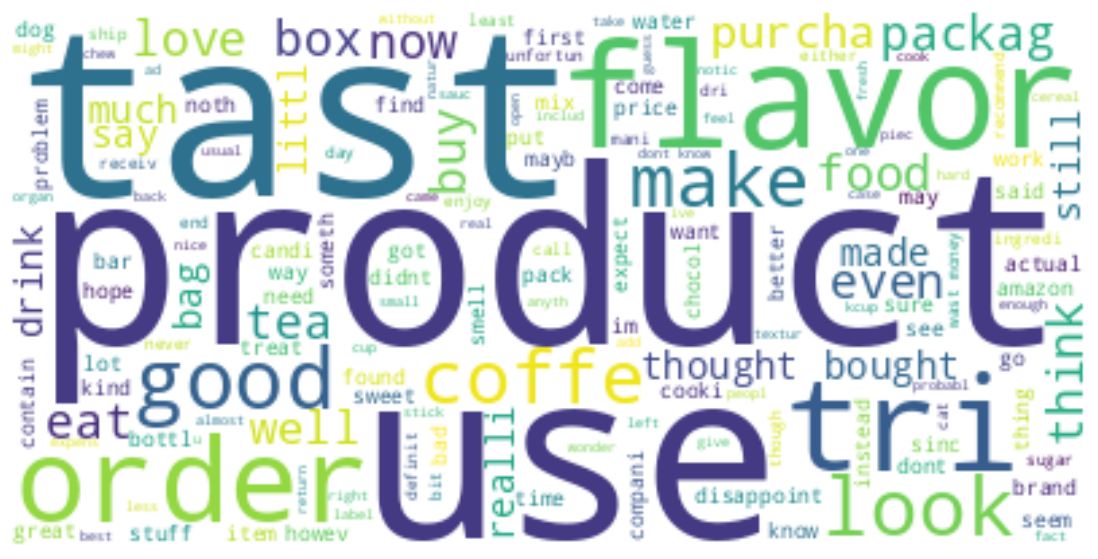

In [22]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Word cloud for Neutral reviews

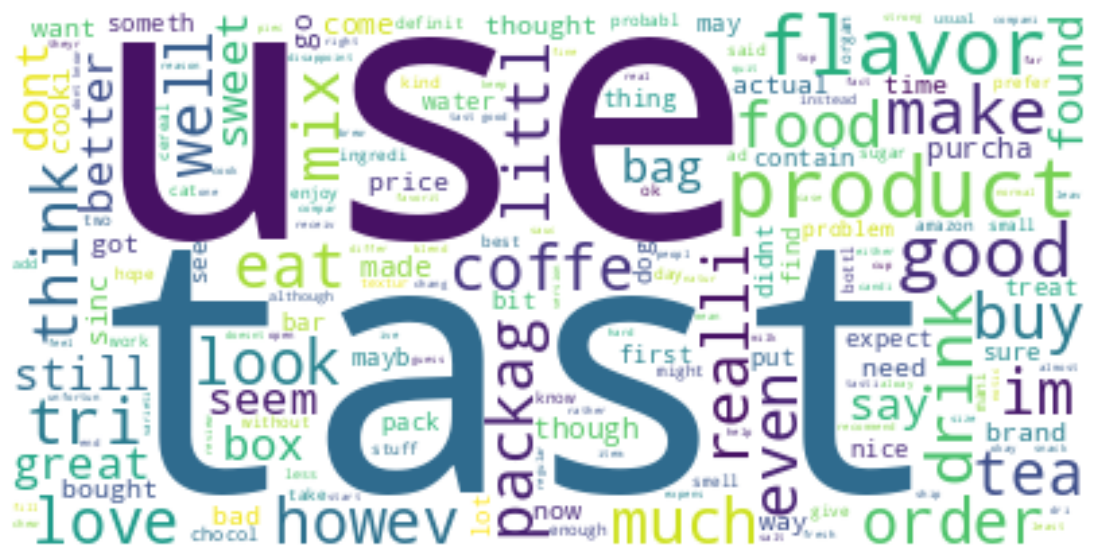

In [23]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

Train Test Split
Train set : 70% of data
Test set : 30% of data

In [24]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=1, stratify=y)

In [25]:
X_train.shape, X_test.shape

((103816,), (25954,))

Vectorization
Bag of Words Vectorizer

In [26]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

TF-IDF Vectorizer

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

Label Encoding

In [28]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


Model Training

In [29]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

In [30]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7100254296062264
Test accuracy score : 0.6804731447946367

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7094571164367728
Test accuracy score : 0.6817446251059567

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7091103490791401
Test accuracy score : 0.6823611004084149

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7088406411343146
Test accuracy score : 0.6826308083532403

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7085227710564845
Test accuracy score : 0.6825152192340295

 ----------------------------------------


In [31]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7149187023194883
Test accuracy score : 0.6813593280419203

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7134160437697464
Test accuracy score : 0.6826308083532403

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7109597749865146
Test accuracy score : 0.683940818370964

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7098616783540109
Test accuracy score : 0.6844802342606149

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7087154195885027
Test accuracy score : 0.6842105263157895

 ----------------------------------------
